# Listwise

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from models.dialogue import UtteranceTransformerDMConfig, UtteranceTransformerDM
from models.listwise import ClfUtteranceSorter


head_dropout_prob = 0.02
encoder_name = 'sentence-transformers/all-mpnet-base-v2'
config = UtteranceTransformerDMConfig(
    num_attention_heads=4,
    attention_probs_dropout_prob=0.02,
    n_layers=4,
    encoder_name=encoder_name,
    embed_turn_ids=False,
    is_casual=False
)
_dialogue_model = UtteranceTransformerDM(config)

_model = ClfUtteranceSorter(
    dialogue_model=_dialogue_model,
    dropout_prob=head_dropout_prob,
    max_n_uts=20
)

model = ClfUtteranceSorter.from_checkpoint(
    path_to_ckpt='/home/alekseev_ilya/dialogue-augmentation/nup/logs/training/listwise-clf-resumed/checkpoints/last.ckpt',
    model=_model,
    map_location='cpu'
)

/home/alekseev_ilya/dialogue-augmentation/VENV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Score vs Shuffling

In [3]:
import json

n_dialogues = 128
dataset = json.load(open('/home/alekseev_ilya/dialogue-augmentation/nup/dialogues/val/0.json', 'r'))[:n_dialogues]

In [4]:
non_reducted, geo_mean, arith_mean = model.score(batch=dataset)

In [5]:
len(arith_mean), len(geo_mean), len(non_reducted), len(non_reducted[1])

(128, 128, 128, 16)

In [7]:
import numpy as np
from tqdm.autonotebook import tqdm
import math
from collections import defaultdict
import pandas as pd

def random_swap(arr, n_swaps):
    """n_swaps must be bounded by len(arr) / 2"""
    arr = arr[:]
    idx_pairs = np.random.choice(len(arr), (n_swaps, 2), replace=False)
    for i, j in idx_pairs:
        arr[i], arr[j] = arr[j], arr[i]
    return arr

grid_size = 11
fraction_swaps_list = np.linspace(0, 1, grid_size)
df_list = []
for frac in tqdm(fraction_swaps_list):
    shuffled_dataset = []
    for dia in dataset:
        n_swaps = math.ceil(frac * (len(dia) // 2))
        shuffled_dataset.append(random_swap(dia, n_swaps))
    non_reducted, geo_mean, arith_mean = model.score(batch=shuffled_dataset)
    df_list.append(pd.DataFrame({
        'frac': frac,
        'geo_mean': geo_mean,
        'arith_mean': arith_mean,
        'min': [np.min(probs) for probs in non_reducted],
        'max': [np.max(probs) for probs in non_reducted]
    }))

100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


In [8]:
df = pd.concat(df_list, axis=0)

<Axes: xlabel='frac', ylabel='arith_mean'>

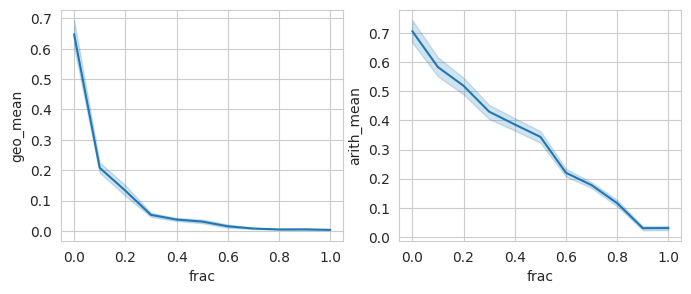

In [10]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.lineplot(data=df, x='frac', y='geo_mean', ax=ax[0])
sns.lineplot(data=df, x='frac', y='arith_mean', ax=ax[1])

- арифметическое среднее жесть как хорошо отражает степень перемешанности
- надо попробовать ариф среднее для пейрвайс, потому что там я считал только геом

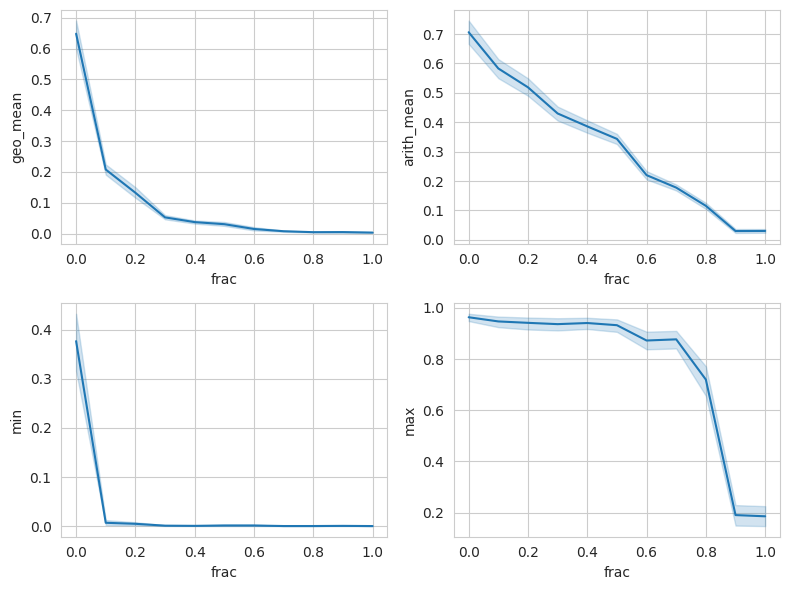

In [12]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(8, 6))

sns.lineplot(data=df, x='frac', y='geo_mean', ax=ax[0, 0])
sns.lineplot(data=df, x='frac', y='arith_mean', ax=ax[0, 1])
sns.lineplot(data=df, x='frac', y='min',  ax=ax[1, 0])
sns.lineplot(data=df, x='frac', y='max',  ax=ax[1, 1])
plt.tight_layout()

- хорошо что минимальная вероятность так сильно проседает т.к. это отражает наличие неправильного шаффла
- плохо что максимальная вероятность так слабо проседает т.к. это должно отражать наличие неправильного шаффла
    - надо конечно еще исследовать какие уттерансы вносят вклад в этот максимум
    - но пока есть гипотеза что это из-за переобучения под конкретные позиции в диалоге?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


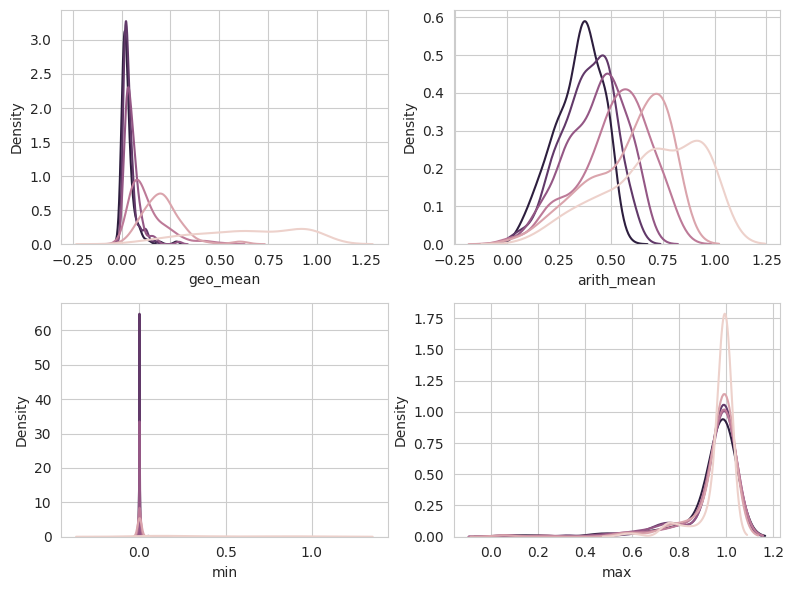

In [16]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(8, 6))

df_f = df[df.frac <= 0.5]
sns.kdeplot(data=df_f, hue='frac', x='geo_mean', ax=ax[0, 0])
sns.kdeplot(data=df_f, hue='frac', x='arith_mean', ax=ax[0, 1])
sns.kdeplot(data=df_f, hue='frac', x='min',  ax=ax[1, 0])
sns.kdeplot(data=df_f, hue='frac', x='max',  ax=ax[1, 1])

for a in ax.flatten():
    a.legend(frameon=False)

plt.tight_layout()

- хорошо что на сильно зашафленных диалогах показывает такой малый скор
- хорошо что на незашафленных диалогах показывает умеренный скор (а не завышенный), это показывает что есть пространство для шаффлов и катов
- плохо что максимум так высок даже на зашафленных диалогах

пришла идея как придумывать аугментации на подобие CLM:
- на каждой позиции выбирать тот уттеранс, вероятность которого быть на данной позиции максимально (жадный декодинг)
- и так далее по аналогии: beam search, top-k, nuclear

## Score vs Position

In [4]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [6]:
[len(dia) for dia in dataset]

[12, 20, 6, 12, 20, 12, 16, 16, 28, 16, 26, 8, 18, 12, 18]

In [9]:
all_scores, _, _ = model.score(batch=[dia for dia in dataset if len(dia) <= 20])

In [13]:
import pandas as pd
import numpy as np

df_list = []
for i_dia, scores in enumerate(all_scores):
    df_list.append(pd.DataFrame({
        'i_dia': i_dia,
        'i_pair': np.arange(len(scores)),
        'score': scores
    }))
df = pd.concat(df_list, axis=0)

In [17]:
def show_positionwise_scores(i_dia):
    speaker_alias = "AB"
    dia = dataset[i_dia]
    scores = df[df.i_dia == i_dia].sort_values('i_pair')['score'].tolist()
    uts = [f'[{speaker_alias[item["speaker"]]}] [score: {score:5.2f}] {item["utterance"]}' for score, item in zip(scores, dia)]
    print('\n'.join(uts))

[A] [score:  0.93] My husband and I are celebrating our anniversary and want to find a great place to stay in town.
[B] [score:  0.63] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
[A] [score:  0.44] I would like a 4 star guesthouse that includes free parking.
[B] [score:  0.20] I have several options for you, is there a particular area you are interested in during your stay?
[A] [score:  0.24] yes should be in the west
[B] [score:  0.14] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book for you?
[A] [score:  0.27] Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course!
[B] [score:  0.17] Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number FKRO2HOW . Will there be anything else?
[A] [score:  0.00] I am wanting to know more about the Cambridge Museum of Technology.
[B] [score:  0.16] Sure, it's located in the ce

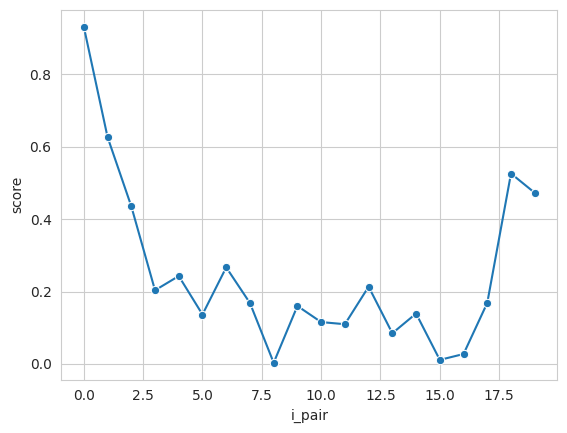

In [24]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

i_dia = 1
show_positionwise_scores(i_dia)
# sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='rel_score', marker='o')
sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='score', marker='o')
plt.show()

модель требует переработки:
- скоры высокие у последней и первой фраз в диалоге, все остальные фразы имеют очень маленький скор
- мейби обучение в CLM-стиле исправит это

## Augmentation demo

In [4]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [5]:
from models.listwise import Decoder

decoder = Decoder(top_k=2)
augmented = model.augment(dataset, decoder)

In [6]:
[len(dia) for dia in dataset]

[12, 20, 6, 12, 20, 12, 16, 16, 28, 16, 26, 8, 18, 12, 18]

In [11]:
[len(dia) for dia in augmented]

[12, 20, 6, 12, 20, 12, 16, 16, 20, 16, 20, 8, 18, 12, 18]

In [7]:
augmented[8]

[{'utterance': 'Are there any accommodations in the east part of town that off free parking?',
  'speaker': 0},
 {'utterance': 'great, what is your departure site?', 'speaker': 1},
 {'utterance': 'What is their star rating?', 'speaker': 0},
 {'utterance': 'It is located at 15-17 norman way, coldhams business park.',
  'speaker': 1},
 {'utterance': 'I will need to leave after 15:45', 'speaker': 0},
 {'utterance': 'it has a two star rating', 'speaker': 1},
 {'utterance': 'I need a train, as well. It should leave on tuesday and go to london liverpool street.',
  'speaker': 0},
 {'utterance': 'And what time will you be needing to leave after or arrive by?',
  'speaker': 1},
 {'utterance': 'Yes that train will work for me.', 'speaker': 0},
 {'utterance': 'for how many people do i book?', 'speaker': 1},
 {'utterance': 'Actually, I do need a taxi to get to the train station. Can you look one up for me?',
  'speaker': 0},
 {'utterance': 'I have booked one seat on TR4276. Your reference number 

In [8]:
dataset[0]

[{'utterance': "I'm looking for a local place to dine in the centre that serves chinese food.",
  'speaker': 0},
 {'utterance': 'I have restaurants matching your criteria in all price ranges. Do you have a preference on price?',
  'speaker': 1},
 {'utterance': 'I need the address, postcode and the price range.',
  'speaker': 0},
 {'utterance': 'Ok how about Charlie Chan, located at Regent Street City Centre. Postcode is cb21db with a cheap price. Can I help you further today?',
  'speaker': 1},
 {'utterance': 'I also need a train. The train should leave after 16:15 and should leave on sunday.',
  'speaker': 0},
 {'utterance': "Can I have more information for the train you're needing? Where are you departing from and arriving to?",
  'speaker': 1},
 {'utterance': 'I am leaving from Cambridge and going to Norwich.',
  'speaker': 0},
 {'utterance': 'I have train TR1840 leaving at 16:36 is that okay?',
  'speaker': 1},
 {'utterance': 'book for 5 people and get me the reference number',
  '

## DecoderListwise

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from models.dialogue import UtteranceTransformerDMConfig, UtteranceTransformerDM
from models.listwise import DecoderUtteranceSorter
from models.listwise import Decoder

head_dropout_prob = 0.02
encoder_name = 'sentence-transformers/all-mpnet-base-v2'
config = UtteranceTransformerDMConfig(
    num_attention_heads=4,
    attention_probs_dropout_prob=0.02,
    n_layers=4,
    encoder_name=encoder_name,
    embed_turn_ids=False,
    is_casual=False
)
_dialogue_model = UtteranceTransformerDM(config)

decoder = Decoder(top_k=2)
model = DecoderUtteranceSorter(
    dialogue_model=_dialogue_model,
    dropout_prob=head_dropout_prob,
    max_n_uts=20,
    decoder=decoder
)

/home/alekseev_ilya/dialogue-augmentation/VENV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [5]:
[len(dia) for dia in dataset]

[12, 20, 6, 12, 20, 12, 16, 16, 28, 16, 26, 8, 18, 12, 18]

In [6]:
dias = [dia for dia in dataset if len(dia) <= 20]
model(dataset[2:4])

(tensor(2.3173, grad_fn=<NllLossBackward0>), 0.49090909090909096)